# Hi all 👋🙃

**This notebook has the main modules of my personal Polar Owl project in a private github repository. While developing this project, I encountered a number of difficulties and the kaggle community has always come to my aid, so I felt that I should publish this work here. I hope this helps you 😊**

![](https://enterprise-insights.dji.com/hs-fs/hubfs/Spraying%20Drone%20GIF%202.gif?width=600&name=Spraying%20Drone%20GIF%202.gif)

# What can you study? 📚

* Frameworks 🛠
    1. pytorch
    2. lightning
    3. torchmetrics
    4. albumentations
    5. opencv (cv2)


* Machine learning 🤖
    1. Segmentation task
    1. Neural Network Architectures (DeepLab, Unet)
    

![](https://media.tenor.com/ow94qLGI8WsAAAAC/ai.gif)

# Important ⚠️

**These are parts of the design work, so it's okay if you don't understand something.
I will try to leave links to sources and help you with questions. Also, you do not have to deal with all the modules.
You can study the specific one that you need, and just use the rest according to the description.
You can also reuse parts of this work in your projects.**

![](https://i.gifer.com/origin/34/34d158fca101006cef587bf1d352295f_w200.gif)

# And so let's get started ⚡️
* **Feel free to ask questions. I will try to answer everyone 🙃**
* **I will also be glad to your vote if you found this work useful.**

## What is a segmentation task?

**Segmentation is a combination of the task of classification with the task of determining the location of an object in a picture. The bottom line is that for each pixel we predict a vector with a size equal to the number of classes. That is, each pixel belongs to k-values, which are the probabilities of belonging to each of the classes. For each pixel, we choose the class with the highest probability. Thus, we get a mask where each pixel belongs to a certain class.**


![](https://static.wixstatic.com/media/4555f1_bc77808b2dfa4e0d8772e5d178a5aee7~mv2.gif)

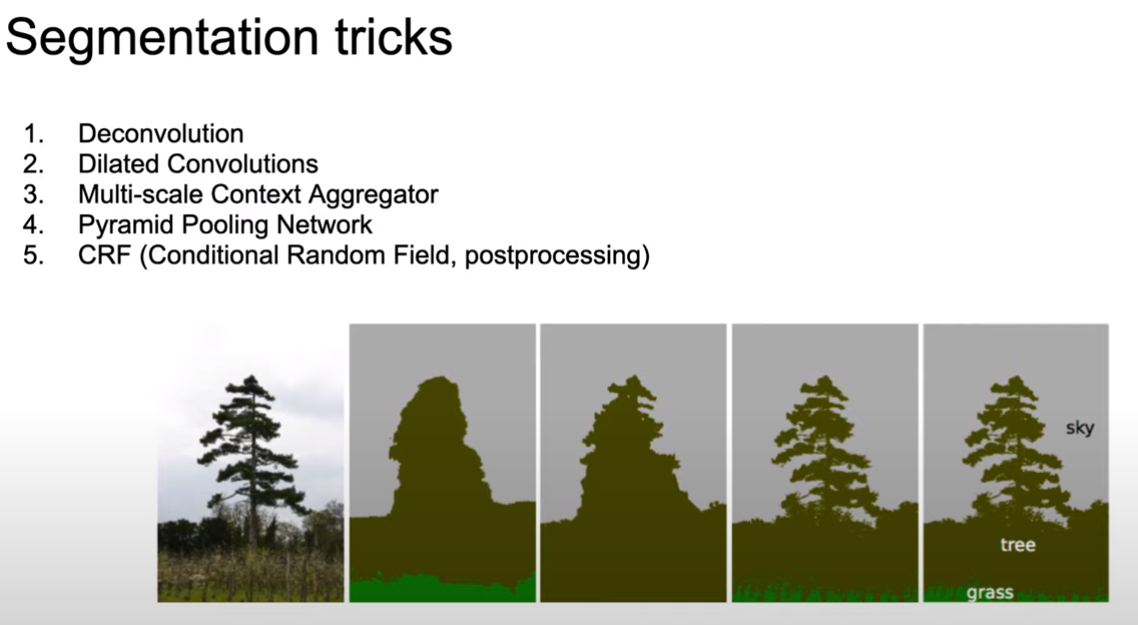

## What is CRF?
**This is a method of post-processing the mask in order to improve the quality of the mask obtained after segmentation. You can find out more at the links below**

* **https://github.com/lucasb-eyer/pydensecrf - github**
* **https://anaconda.org/conda-forge/pydensecrf - anaconda**

## What is lightning?
**Lightning is a framework wrapper for pytorch. It has a lot of useful functions that we would have to implement manually. Lightning has its own style of writing code, which allows you to make it modular and readable. However, I do not recommend taking up lightning unless you have studied pytorch. Below I will leave links to useful sources.**
* **Link to Official Lightning Website: https://pytorchlightning.ai/index.html**
* **Link to the lightning tutorial: https://pytorchlightning.ai/tutorials**
* **Link to a brief lightning training: https://www.youtube.com/watch?v=Hgg8Xy6IRig&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=21**

![](https://learnopencv.com/wp-content/uploads/2020/05/Annotation-2020-05-03-191339.png)

## EDA (Explorational Data Analysis) 📊
* We will look at the pictures
* Let's get to know the tags
* Let's decide with what marks we will train
* Let's verify the quality of the data

**EDA libraries**

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

**Pathes**

In [ ]:
IMAGE_PATH = "data/AerialDroneSemanticSegmentationDataset/dataset/semantic_drone_dataset/original_images"
TARGET_PATH = "data/AerialDroneSemanticSegmentationDataset/dataset/semantic_drone_dataset/label_images_semantic"
COLOR_TARGET_PATH = "data/AerialDroneSemanticSegmentationDataset/RGB_color_image_masks/RGB_color_image_masks"
COLORMAP_PATH = "data/AerialDroneSemanticSegmentationDataset/class_dict_seg.csv"

## Helper functions for EDA
* create_dataset() - Creating a dataframe
* imshow() - Output image with mask

In [ ]:
def create_dataset(data_path: str, target_path: str) -> pd.DataFrame:
    dict_paths = {"image": [], "mask": []}

    for dir_name, _, filenames in os.walk(data_path):
        for filename in filenames:
            name = filename.split(".")[0]
            dict_paths["image"].append(f"{data_path}/{name}.jpg")
            dict_paths["mask"].append(f"{target_path}/{name}.png")

    dataframe = pd.DataFrame(
        data=dict_paths, index=np.arange(0, len(dict_paths["image"]))
    )

    return dataframe


def imshow(dataframe: pd.DataFrame, num: int = 3, mask: bool = True) -> None:
    for i in range(num):
        image, mask = df.iloc[i]
        image = Image.open(image)
        mask = Image.open(mask)
        print(f"Image shape: {np.asarray(image).shape}")
        print(f"Mask shape: {np.asarray(mask).shape}")
        plt.imshow(image)
        if mask:
            plt.imshow(mask, alpha=0.5)
        text = "with" if mask else "without"
        plt.title(f"Image {text} mask")
        plt.show()

**Let's see the images**

In [ ]:
df = create_dataset(IMAGE_PATH, TARGET_PATH)
imshow(df)

## Outcome:
* Mask size: 6000x4000
* Image size: 3x6000x4000
* Masks and images are intact
* Images have correct masks

**We use single-channel masks because it's computationally advantageous and because our targets are 23 classes, which are represented by numbers from 0 to 22. So the masks are just a matrix with the values ​​of each class in the corresponding pixels.**

## About network post processing or how do we use neural network prediction?
**Our task at the end of the training will be to obtain a tensor consisting of matrices. Each matrix belongs to one of the classes. The class matrix consists of the probabilities that each pixel of the picture belongs to this class. Next, we will apply the argmax method, which will turn our tensor into a matrix, each value of which will be the index of the class with the highest probability.
In total, we have a matrix with values from 0 to 22. Next, we will convert it into a three-channel image and we can display or save**

# TransformPipelineModule 🏗

**We only have 400 pictures. This is extremely small for the segmentation of 23 classes. I decided to get out of the problem by creating this pipeline that argues pictures. To get a better result, you need to experiment with it. You don't need to go into the details of how it works.**

1. height - image height

2. width - image width

3. cut - the number of random cuts of parts of the picture

4. defocus - image defocus
  
5. dropout_pieces - parts of the picture falling out

6. dropout_pixel - grainy dropout of pixels in the picture

7. horizontal_lines - add horizontal lines effect

8. vertical_lines - add vertical lines effect

9. spatial - add spatial transformations (perspective, angle)

10. rain - add rain and cloudy weather

11. sunny - add highlights and sunshine

12. snow - add snowfall

13. foggy - add fog

**Dependencies**

In [ ]:
import albumentations as A
import numpy as np
import torch
import cv2
from colorama import Fore

**Module**

In [ ]:
class TransformPipelineModule:
    """
    This high-level API manages the transformation pipeline
    Includes dynamic adjustment of conversion parameters based on the size of the input image.
    The ratio size of the input image to the desired output signal size calculated,
     and then the conversion parameters adjusted accordingly.
    """

    def __init__(
        self,
        height: int,
        width: int,
        cut: int = 0,
        defocus: bool = False,
        pixel_dropout: bool = False,
        pieces_dropout: bool = False,
        horizontal_lines: bool = False,
        vertical_lines: bool = False,
        spatial: bool = True,
        rain: bool = True,
        sunny: bool = True,
        snow: bool = True,
        foggy: bool = True,
    ):

        # Customization options.
        self.height = height
        self.width = width
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Image tearing.
        self.defocus = defocus
        self.pixel_dropout = pixel_dropout
        self.pieces_dropout = pieces_dropout
        self.horizontal_lines = horizontal_lines
        self.vertical_lines = vertical_lines
        self.__damage = any(
            [
                self.defocus,
                self.pieces_dropout,
                self.pieces_dropout,
                self.horizontal_lines,
                self.vertical_lines,
            ]
        )

        self._defocus_transform = None
        self._pixel_dropout_transform = None
        self._pieces_dropout_transform = None
        self._horizontal_lines_transform = None
        self._vertical_lines_transform = None

        # Weather changes.
        self.rain = rain
        self.sunny = sunny
        self.snow = snow
        self.foggy = foggy
        self.__weather = any([self.rain, self.sunny, self.snow, self.foggy])

        self._rain_transform = None
        self._sunny_transform = None
        self._snow_transform = None
        self._foggy_transform = None

        # Standard transforms.
        self.cut = cut
        self.spatial = spatial

        self._cut_transforms = None
        self._spatial_transforms = None
        self._base_transforms = None

        self.__debug_state = None

    def __str__(self) -> str:
        return self.__class__.__name__

    def __repr__(self) -> str:
        return f"{self.__class__}: {self.__dict__}"

    def __len__(self) -> int:
        # Returns the number blocks in the pipeline.
        return sum(
            [int(value) for value in self.__dict__.values() if type(value) is bool]
        )

    def __activate_debugging(self, image: np.array, mask: np.array) -> tuple:
        """
        Activates the debugging mode.
        Transforms the image without translation into tensors.
        """

        transform = A.Resize(
            height=self.height, width=self.width, interpolation=cv2.INTER_LINEAR
        )
        transformed = transform(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]

        if not self.__debug_state:
            print(Fore.YELLOW + f"|| Debugging mode activated ||" + Fore.WHITE)
            self.__debug_state = True
        return image, mask

    def __weather_adaptation(self) -> None:
        """
        Creates weather effects.
        Namely: rain, sunny, snow, fog.
        """

        # Rain effects.
        if self.rain:
            self._rain_transform = A.RandomRain(
                slant_lower=-10,
                slant_upper=10,
                drop_length=15,
                drop_width=1,
                drop_color=(200, 200, 200),
                blur_value=12,
                brightness_coefficient=0.52,
                rain_type="heavy",
                p=0.25,
            )

        # Sunny effects.
        if self.sunny:
            self._sunny_transform = A.RandomSunFlare(
                flare_roi=(0, 0, 1, 1),
                angle_lower=0,
                angle_upper=1,
                num_flare_circles_lower=4,
                num_flare_circles_upper=8,
                src_radius=100,
                src_color=(255, 255, 255),
                p=0.25,
            )

        # Snow effects.
        if self.snow:
            self._snow_transform = A.RandomSnow(
                snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, p=0.25
            )

        # Fog effects.
        if self.foggy:
            self._foggy_transform = A.RandomFog(
                fog_coef_lower=0.3, fog_coef_upper=0.4, alpha_coef=0.1, p=0.01
            )

    def __damage_adaptation(self) -> None:
        """
        Creates image corruption effects.
        Namely: defocus, pixel dropout, vertical stripes, horizontal stripes, loss parts of the image.
        """

        # defocus.
        if self.defocus:
            self._defocus_transform = A.Defocus(
                radius=(0.5, 2.5), alias_blur=(0.1, 0.5), p=0.05
            )

        # pixel dropout.
        if self.pixel_dropout:
            self._pixel_dropout_transform = A.PixelDropout(dropout_prob=0.01, p=0.05)

        # loss parts of the image.
        if self.pieces_dropout:
            self._pieces_dropout_transform = A.CoarseDropout(
                max_holes=50,
                max_height=512,
                max_width=2,
                min_holes=10,
                min_height=128,
                min_width=1,
                fill_value=0,
                mask_fill_value=None,
                p=0.05,
            )

        # horizontal stripes.
        if self.horizontal_lines:
            self._horizontal_lines_transform = A.CoarseDropout(
                max_holes=50,
                max_height=2,
                max_width=512,
                min_holes=10,
                min_height=1,
                min_width=128,
                fill_value=0,
                mask_fill_value=None,
                p=0.05,
            )

        # vertical stripes.
        if self.vertical_lines:
            self._vertical_lines_transform = A.CoarseDropout(
                max_holes=50,
                max_height=8,
                max_width=8,
                min_holes=10,
                min_height=2,
                min_width=2,
                fill_value=0,
                mask_fill_value=None,
                p=0.05,
            )

    def __cut_adaptation(self) -> None:
        # Includes three blocks: single, double and triple slice.
        # Single cut of the image.
        if self.cut == 1:
            self._cut_transforms = A.Compose(
                [A.RandomCrop(width=2667, height=4000, p=0.15)]
            )

        # Double cut the image.
        elif self.cut == 2:
            self._cut_transforms = A.Compose(
                [
                    A.RandomCrop(width=2667, height=4000, p=0.10),
                    A.RandomCrop(width=1283, height=2000, p=0.05),
                ]
            )

        # Triple cut the image.
        else:
            self._cut_transforms = A.Compose(
                [
                    A.RandomCrop(width=2667, height=4000, p=0.15),
                    A.RandomCrop(width=1283, height=2000, p=0.10),
                    A.RandomCrop(width=855, height=1333, p=0.05),
                ]
            )

    def __spatial_adaptation(self) -> None:
        """
        Spatial transformations.
        Namely: horizontal flip, vertical flip, affine, perspective.
        """

        if self.spatial:
            self._spatial_transforms = A.Compose(
                [
                    # horizontal flip.
                    A.HorizontalFlip(p=0.5),
                    # vertical flip.
                    A.VerticalFlip(p=0.5),
                    # affine.
                    A.Affine(
                        rotate=[-15, 15],
                        p=0.35,
                        mode=cv2.BORDER_REFLECT,
                        interpolation=cv2.INTER_LINEAR,
                    ),
                    # perspective.
                    A.Perspective(
                        scale=(0.05, 0.25),
                        pad_mode=cv2.BORDER_REFLECT,
                        interpolation=cv2.INTER_LINEAR,
                        p=1,
                    ),
                ]
            )

    def __base_transform_adaptation(self) -> None:
        """
        A must-have composition.
        Translates the image into tensors.
        Normalizes tensors.
        Resizes.
        """

        self._base_transforms = A.Compose(
            [
                A.Resize(height=self.height, width=self.width),
                A.Normalize(
                    mean=self.mean,
                    std=self.std,
                ),
                pytorch.ToTensorV2(),
            ]
        )

    def __pipeline_adaptation(self) -> None:
        """
        Causes transformation pipeline modules to adapt.
        Verifies that modules participate in the pipeline.
        """

        if self.__damage:
            self.__damage_adaptation()
        if self.__weather:
            self.__weather_adaptation()
        if self.cut:
            self.__cut_adaptation()
        if self.spatial:
            self.__spatial_adaptation()
        self.__base_transform_adaptation()

    def __call__(self, image: np.array, mask: np.array, debug_mode: bool = False):
        self.__pipeline_adaptation()

        # Weather transformations.
        # Rain
        if self._rain_transform:
            transformed = self._rain_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Sunny.
        if self._sunny_transform:
            transformed = self._sunny_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Snow.
        if self._snow_transform:
            transformed = self._snow_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Foggy.
        if self._foggy_transform:
            transformed = self._foggy_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Damage transformation
        # Defocus.
        if self._defocus_transform:
            transformed = self._defocus_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Pixel dropout.
        if self._pixel_dropout_transform:
            transformed = self._pixel_dropout_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Pieces dropout.
        if self._pieces_dropout_transform:
            transformed = self._pieces_dropout_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Horizontal lines.
        if self._horizontal_lines_transform:
            transformed = self._horizontal_lines_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Vertical lines.
        if self._vertical_lines_transform:
            transformed = self._vertical_lines_transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Cut transformation.
        if self.cut:
            transformed = self._cut_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Spatial transformation.
        if self.spatial:
            transformed = self._spatial_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        # Mandatory Transformations for Learning
        if not debug_mode:
            transformed = self._base_transforms(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]
        else:
            image, mask = self.__activate_debugging(image=image, mask=mask)

        return {"image": image, "mask": mask}

# PhotopicVisionDataset 📙

**This module is a dataset and operates with paths to images and masks, and is also responsible for splitting data, opening files with images and issuing them.**

**This class is used only to organize the work of the data module class. It should not be used to manage data partitioning, etc. However, you can use this module separately in your project as it is independent of other modules.**

1. stage - specify the part of the data you want to get (train, test, val)
2. target_path - path to the label or target value (masks in our case)
3. data_path - path to received data (images)
4. transforms - composition of transformations (I usually collect it, but you can create your own composition)
5. test_size - share of test data
6. train_size - share of processing data
7. val_size - share of verified data
8. shuffle - whether to shuffle the data
9. random_state - seed value of the random number generator

**Dependencies**

In [ ]:
import albumentations as A
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import os
from typing import Any

**Module**

In [ ]:
class PhotopicVisionDataset(Dataset):
    def __init__(
        self,
        stage: str,
        target_path: str,
        data_path: str,
        transforms: Any,
        test_size: float = 0.15,
        train_size: float = 0.7,
        val_size: float = 0.15,
        shuffle: bool = True,
        random_state: int = 42,
    ):

        self.__attribute_checking(
            target_path,
            data_path,
            test_size,
            train_size,
            val_size,
            stage,
            shuffle,
            random_state,
        )

        self.target_path = target_path
        self.data_path = data_path
        self.transforms = transforms
        self.test_size = test_size
        self.train_size = train_size
        self.val_size = val_size
        self.stage = stage
        self.shuffle = shuffle
        self.random_state = random_state
        self.total_len = None
        self._X, self._Y = self.__create_dataset()

    @staticmethod
    def __type_checking(
        target_path: str,
        data_path: str,
        stage: str,
        shuffle: bool,
        test_size: float,
        train_size: float,
        val_size: float,
        random_state: int,
    ) -> None:

        assert isinstance(target_path, str)
        assert isinstance(data_path, str)
        assert isinstance(test_size, float)
        assert isinstance(train_size, float)
        assert isinstance(val_size, float)
        assert isinstance(stage, str)
        assert isinstance(shuffle, bool)
        assert isinstance(random_state, int)

    @staticmethod
    def __split_checking(train_size: float, test_size: float, val_size: float) -> None:
        total_size = train_size + test_size + val_size
        assert total_size == 1

    @staticmethod
    def __path_checking(target_path: str, data_path: str) -> None:
        assert os.path.isdir(data_path)
        assert os.path.isdir(target_path)

    @staticmethod
    def __stage_checking(stage: str) -> None:
        assert stage in ["train", "test", "val"]

    @classmethod
    def __attribute_checking(
        cls,
        target_path: str,
        data_path: str,
        test_size: float,
        train_size: float,
        val_size: float,
        stage: str,
        shuffle: bool,
        random_state: int,
    ) -> None:

        cls.__type_checking(
            target_path=target_path,
            data_path=data_path,
            train_size=test_size,
            test_size=test_size,
            val_size=val_size,
            stage=stage,
            shuffle=shuffle,
            random_state=random_state,
        )

        cls.__split_checking(
            train_size=train_size, test_size=test_size, val_size=val_size
        )

        cls.__path_checking(target_path=target_path, data_path=data_path)

        cls.__stage_checking(stage=stage)

    def __create_dataset(self) -> dict:
        dict_paths = {"image": [], "mask": []}

        for dir_name, _, filenames in os.walk(self.data_path):
            for filename in filenames:
                name = filename.split(".")[0]
                dict_paths["image"].append(f"{self.data_path}/{name}.jpg")
                dict_paths["mask"].append(f"{self.target_path}/{name}.png")

        dataframe = pd.DataFrame(
            data=dict_paths, index=np.arange(0, len(dict_paths["image"]))
        )

        self.total_len = len(dataframe)
        x_data = dataframe["image"].values
        y_data = dataframe["mask"].values
        data_dict = self.__split_data(x_data=x_data, y_data=y_data)
        return data_dict[self.stage]

    def __split_data(self, x_data: np.array, y_data: np.array) -> dict:

        total_eval_size = self.test_size + self.val_size
        test_size = 1 / (total_eval_size / self.test_size)
        val_size = 1 / (total_eval_size / self.val_size)

        x_train, x_test, y_train, y_test = train_test_split(
            x_data,
            y_data,
            train_size=self.train_size,
            test_size=total_eval_size,
            random_state=self.random_state,
            shuffle=self.shuffle,
        )

        x_test, x_val, y_test, y_val = train_test_split(
            x_test,
            y_test,
            train_size=val_size,
            test_size=test_size,
            random_state=self.random_state,
            shuffle=self.shuffle,
        )
        return {
            "train": (x_train, y_train),
            "test": (x_test, y_test),
            "val": (x_val, y_val),
        }

    def __len__(self) -> int:
        return len(self._X)

    def __getitem__(self, idx) -> tuple:
        data_path, target_path = self._X[idx], self._Y[idx]
        image = cv2.imread(data_path, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
        transformed = self.transforms(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]
        return image, mask

# PhotopicVisionDataModule 📖
**Manage your dataset through this class (PhotopicVisionDataModule) and not through the PhotopicVisionDataset!**

**The data module is responsible for uploading data to RAM, creating data loaders, managing the number of upload threads (it makes no sense to set more threads than you have cores in the processor), as well as the number of mini-batches**

1. stage - specify the part of the data you want to get (train, test, val)
2. target_path - path to the label or target value (masks in our case)
3. data_path - path to received data (images)
4. transforms - composition of transformations (I usually collect it, but you can create your own composition)
5. test_size - share of test data
6. train_size - share of processing data
7. val_size - share of verified data
8. shuffle - whether to shuffle the data
9. random_state - seed value of the random number generator

**Dependencies**

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import albumentations as A
import torchvision.transforms as T
import albumentations.pytorch as pytorch
from typing import Union

**Module**

In [ ]:
class PhotopicVisionDataModule(pl.LightningDataModule):
    def __init__(
        self,
        target_path: str,
        data_path: str,
        transform: Union[T.Compose, A.Compose],
        train_size: float = 0.67,
        val_size: float = 0.165,
        test_size: float = 0.165,
        batch_size: int = 4,
        num_workers: int = 4,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.target_path = target_path
        self.data_path = data_path
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        self.data_train = None
        self.data_val = None
        self.data_test = None
        self.data_predict = None
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.train_transform = transform

        self.eval_transform = A.Compose(
            [
                A.Resize(height=transform.height, width=transform.width),
                A.Normalize(mean=self.mean, std=self.std),
                pytorch.ToTensorV2(),
            ]
        )

    def setup(self, stage: str = None) -> None:
        self.data_train = PhotopicVisionDataset(
            target_path=self.target_path,
            data_path=self.data_path,
            transforms=self.train_transform,
            stage="train",
            train_size=self.train_size,
            test_size=self.test_size,
            val_size=self.val_size,
            shuffle=True,
            random_state=42,
        )

        self.data_val = PhotopicVisionDataset(
            target_path=self.target_path,
            data_path=self.data_path,
            transforms=self.eval_transform,
            stage="val",
            train_size=self.train_size,
            test_size=self.test_size,
            val_size=self.val_size,
            shuffle=True,
            random_state=42,
        )

        self.data_test = PhotopicVisionDataset(
            target_path=self.target_path,
            data_path=self.data_path,
            transforms=self.eval_transform,
            stage="test",
            train_size=self.train_size,
            test_size=self.test_size,
            val_size=self.val_size,
            shuffle=True,
            random_state=42,
        )

        self.data_predict = PhotopicVisionDataset(
            target_path=self.target_path,
            data_path=self.data_path,
            transforms=self.eval_transform,
            stage="test",
            train_size=self.train_size,
            test_size=self.test_size,
            val_size=self.val_size,
            shuffle=True,
            random_state=42,
        )

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset=self.data_predict,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

# LightningPhotopicVisionModule ⚡️

**This module is responsible for training the model. It has dependencies in the form of a data module and a model. That is, for it to work, you must create a model and use the data module to upload data, depending on the training stage. This is probably one of the most important modules, as it organizes the entire system of training and evaluation of the model.**

1. model - neural network model for its training
2. example_input_array - example of an input array to a neural network
3. optim_dict - dictionary with optimizer and its parameters
4. lr - learning rate
5. num_classes - number of classes

**Dependencies**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, JaccardIndex, FBetaScore
from typing import Any, Union

**Module**

In [ ]:
class LightningPhotopicVisionModule(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        example_input_array: Union[list, tuple],
        optim_dict: dict = None,
        lr: float = None,
        num_classes: int = 23,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.zeros(size=example_input_array)
        self.num_classes = num_classes
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optim_dict = optim_dict
        self._device = "cuda" if torch.cuda.is_available else "cpu"

        self.step_outputs = {
            "loss": [],
            "accuracy": [],
            "jaccard_index": [],
            "fbeta_score": [],
        }

        self.metrics = {
            "accuracy": Accuracy(
                task="multiclass",
                threshold=0.5,
                num_classes=num_classes,
                validate_args=True,
                ignore_index=None,
                average="micro",
            ).to(self._device),
            "jaccard_index": JaccardIndex(
                task="multiclass",
                threshold=0.5,
                num_classes=num_classes,
                validate_args=True,
                ignore_index=None,
                average="macro",
            ).to(self._device),
            "fbeta_score": FBetaScore(
                task="multiclass",
                beta=1.0,
                threshold=0.5,
                num_classes=num_classes,
                average="micro",
                ignore_index=None,
                validate_args=True,
            ).to(self._device),
        }

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage: str) -> torch.Tensor:
        x, y = batch

        assert x.ndim == 4
        assert x.max() <= 3 and x.min() >= -3
        assert y.ndim == 3
        assert y.max() <= 22 and y.min() >= 0

        logites = self.forward(x.to(torch.float32))
        activated = F.softmax(input=logites, dim=1)
        predictions = torch.argmax(activated, dim=1)
        loss = self.criterion(logites, y.to(torch.int64))

        accuracy = self.metrics["accuracy"](predictions, y)
        jaccard_index = self.metrics["jaccard_index"](predictions, y)
        fbeta_score = self.metrics["fbeta_score"](predictions, y)

        self.step_outputs["loss"].append(loss)
        self.step_outputs["accuracy"].append(accuracy)
        self.step_outputs["jaccard_index"].append(jaccard_index)
        self.step_outputs["fbeta_score"].append(fbeta_score)
        return loss

    def shared_epoch_end(self, stage: Any):
        loss = torch.mean(torch.tensor([loss for loss in self.step_outputs["loss"]]))

        accuracy = torch.mean(
            torch.tensor([accuracy for accuracy in self.step_outputs["accuracy"]])
        )

        jaccard_index = torch.mean(
            torch.tensor(
                [jaccard_index for jaccard_index in self.step_outputs["jaccard_index"]]
            )
        )

        fbeta_score = torch.mean(
            torch.tensor(
                [fbeta_score for fbeta_score in self.step_outputs["fbeta_score"]]
            )
        )

        for key in self.step_outputs.keys():
            self.step_outputs[key].clear()

        metrics = {
            f"{stage}_loss": loss,
            f"{stage}_accuracy": accuracy,
            f"{stage}_jaccard_index": jaccard_index,
            f"{stage}_fbeta_score": fbeta_score,
        }
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch: Any, batch_idx: Any):
        return self.shared_step(batch=batch, stage="train")

    def on_train_epoch_end(self) -> None:
        return self.shared_epoch_end(stage="train")

    def validation_step(self, batch: Any, batch_idx: Any):
        return self.shared_step(batch=batch, stage="val")

    def on_validation_epoch_end(self) -> None:
        return self.shared_epoch_end(stage="val")

    def test_step(self, batch: Any, batch_idx: Any):
        return self.shared_step(batch=batch, stage="test")

    def on_test_epoch_end(self) -> None:
        return self.shared_epoch_end(stage="test")

    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0):
        x, y = batch

        assert x.ndim == 4
        assert x.max() <= 3 and x.min() >= -3
        assert y.ndim == 3
        assert y.max() <= 22 and y.min() >= 0

        logites = self.forward(x)
        activated = F.softmax(input=logites, dim=1)
        predictions = torch.argmax(activated, dim=1)
        return predictions

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.hparams.lr)

        scheduler_dict = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=optimizer, patience=5
            ),
            "interval": "epoch",
            "monitor": "val_loss",
        }

        optimization_dictionary = {
            "optimizer": optimizer,
            "lr_scheduler": scheduler_dict,
        }
        return self.optim_dict if self.optim_dict else optimization_dictionary

# Learning Launchpad 🎛

**The code blocks below are a logically broken down learning dashboard. Namely, the main() function and its call with the current settings. Everything is built in the image of a conveyor. You can pre-create multiple models with different parameters and optimizers and pass them to the pipeline loop.**

# Segmentation Models Pytorch

![](https://i.ibb.co/dc1XdhT/Segmentation-Models-V2-Side-1-1.png)

**This framework contains models for segmentation. It is very comfortable. You can assemble your models from different blocks. If you see it for the first time, I advise you to read the documentation**

* https://segmentation-modelspytorch.readthedocs.io/en/latest/ <- Docs
* https://github.com/qubvel/segmentation_models.pytorch <- GitHub

**Dependencies**

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
import torch
import segmentation_models_pytorch as smp
import warnings
from typing import Union, Any
from colorama import Fore

**Module**

* This function is called in the generalizing loop. Thus, you can manage the pipeline quite flexibly and train several models at once.

In [ ]:
def main(
    callbacks: list,
    model: Union[list, tuple],
    logger: TensorBoardLogger,
    data_path: str,
    target_path: str,
    optim_dict: dict,
    example_input_array: Union[list, tuple],
    transforms_dict: dict,
) -> None:

    # Trainer
    trainer = pl.Trainer(
        fast_dev_run=False,
        accelerator="auto",
        strategy="auto",
        devices="auto",
        num_nodes=1,
        logger=logger,
        callbacks=callbacks,
        max_epochs=80,
        min_epochs=35,
    )

    # Transforms Module
    if not transforms_dict:
        transforms = TransformPipelineModule(
            height=704,
            width=1056,
            cut=0,
            defocus=True,
            pixel_dropout=False,
            pieces_dropout=False,
            horizontal_lines=False,
            vertical_lines=False,
            spatial=True,
            rain=True,
            sunny=True,
            snow=False,
            foggy=False,
        )
    else:
        transforms = TransformPipelineModule(**transforms_dict)

    # Datamodule
    datamodule = PhotopicVisionDataModule(
        target_path=target_path,
        data_path=data_path,
        transform=transforms,
        train_size=0.80,
        val_size=0.1,
        test_size=0.1,
        batch_size=2,
        num_workers=2,
    )

    # LightningModule
    lightning_model = LightningPhotopicVisionModule(
        model=model,
        optim_dict=optim_dict,
        lr=3e-4,
        example_input_array=example_input_array,
    )

    # Start training
    trainer.fit(model=lightning_model, datamodule=datamodule)

## Run Constants

In [ ]:
# Run Constants
SEED: int = 42
ACTION: str = "ignore"
DATA_PATH: str = (
    "data/AerialDroneSemanticSegmentationDataset/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
)
TARGET_PATH: str = (
    "data/AerialDroneSemanticSegmentationDataset/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
)
MATMUL_PRECISION = "medium"  # ["medium", "high"]
EXPERIMENT: str = "DeepLabV3Plus"
CHECKPOINT: Any = None

# Model Constants
CLASSES: int = 23
IN_CHANNELS = 3

## Callbacks ⛓

**These classes allow you to prevent retraining of the model. In short, there are many similar classes in lightning, and each is useful in its own way. Here I have summarized the main**

In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        dirpath=f"models/{EXPERIMENT}",
        filename="{epoch}_{val_loss:.2f}_{val_accuracy:.2f}",
        save_top_k=10,
        monitor="val_loss",
        mode="min",
    ),
    EarlyStopping(
        monitor="val_loss", min_delta=2e-4, patience=8, verbose=False, mode="min"
    ),
    LearningRateMonitor(logging_interval="step"),
]

## Frameworks config 🔩

In [ ]:
warnings.filterwarnings(action=ACTION)
pl.seed_everything(seed=SEED)
torch.set_float32_matmul_precision(MATMUL_PRECISION)

# TensorBoard Logger 🔖
**TensorBoard will allow us to visualize the learning process. This is a useful feature, because you no longer need to manually output graphs. This tool is pre-installed in pytorch by default and therefore in lightning.**
* **Link to the documentation for pytorch: https://pytorch.org/docs/stable/tensorboard.html** 
* **Link to a lesson on TensprBoard: https://www.youtube.com/watch?v=VJW9wU-1n18**

![](https://www.tensorflow.org/static/tensorboard/images/tensorboard.gif?hl=ru)

In [ ]:
# TensorBoard Logger
logger = TensorBoardLogger(save_dir="./logs", name=EXPERIMENT)

# What models for the task of segmentation are there?
**Here you can see a list of different models for segmentation. I will not describe each model, as it is quite long, but I will leave you links to the sources**

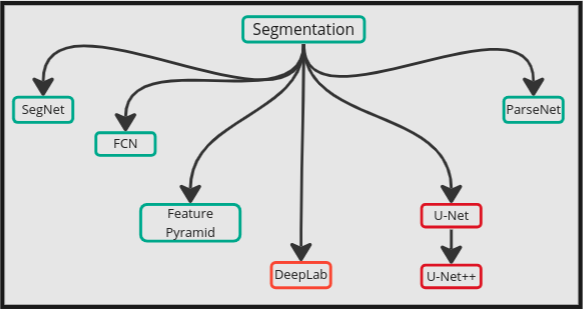

## Unet
* **https://blog.paperspace.com/unet-architecture-image-segmentation/**
* **https://en.wikipedia.org/wiki/U-Net**

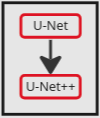

## DeepLab 
* **https://kobiso.github.io/research/research-deeplab/**
* **https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/**

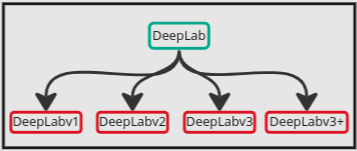

# Models 🤖
**Create many different models and train them on the production line!**

In [ ]:
# Set of models
deeplab_v3_plus_resnet34 = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_channels=256,
    decoder_atrous_rates=(6, 12, 24),
    in_channels=IN_CHANNELS,
    classes=CLASSES,
    activation=None,
)

# Dict of models 🗂
**And then put the models with all the information you need into this dictionary. It turns out a dictionary, which consists of dictionaries with models and their information. You can also add unique optimizers and parameters to each model for the transformation pipeline**

* "deeplab_v3_plus_resnet34" - name of your model 

* "model": deeplab_v3_plus_resnet34 - initialized model class

* "optim_dict": {"optimizer": optimizer, "lr_scheduler": scheduler_dict} - a dictionary that contains the optimizer, scheduler and their arguments. Thus, even the same models can be trained in different ways.

* "transforms_dict": {
    height=704,
    width=1056,
    cut=0,
    defocus=True,
    pixel_dropout=False,
    pieces_dropout=False,
    horizontal_lines=False,
    vertical_lines=False,
    spatial=True,
    rain=True,
    sunny=True,
    snow=False,
    foggy=False
    } - a dictionary that contains the image transformation pipeline arguments
    
* "example_input_array": [1, 3, 704, 1056] - an example of the size of the input data on which to learn the neural network

In [ ]:
models = {
    "deeplab_v3_plus_resnet34": {
        "model": deeplab_v3_plus_resnet34,  # Your model
        "optim_dict": None,  # Optimization options
        "transforms_dict": None,  # Transform Options
        "example_input_array": [
            1,
            3,
            704,
            1056,
        ],  # An example of the size of the input data on which to learn the neural network
    },
    # Add your dictionaries with models and their parameters as in the example
}

# On startup learning pipline 💫

In [ ]:
#  On startup
if __name__ == "__main__":

    # Model Loop
    phase = 0
    phases = len(models)
    for (
        key,
        value,
    ) in models.items():
        print(Fore.GREEN + f"\n|| Phase {phase}\n" f"|| Model: {key}\n" + Fore.WHITE)

        model = value["model"]
        optim_dict = value["optim_dict"]
        example_input_array = value["example_input_array"]
        transforms_dict = value["transforms_dict"]

        main(
            callbacks=callbacks,
            model=model,
            logger=logger,
            data_path=DATA_PATH,
            target_path=TARGET_PATH,
            optim_dict=optim_dict,
            example_input_array=example_input_array,
            transforms_dict=transforms_dict,
        )

        phase += 1
        phases -= 1
        print(
            Fore.GREEN + f"\n|| Phase {phase} passed successfully!\n"
            f"|| Name: {key}\n"
            f"|| Models left: {phases}\n" + Fore.WHITE
        )

## How to record and visualize metrics?
**TensorBoard has created a logs folder, and lightning logs our metrics there at different stages of training. This is very convenient and now we can run TensorBoard to see how the training is going**
> Download the logs folder to your computer and enter the command below in the terminal

In [ ]:
!tensorboard --logdir=logs

# Check Point 🏁

* Let's get results

* Let's check the work

* Learn how to work with model inference

**Control point dependencies**

In [ ]:
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt

**Let's check the folder where our weights were saved, and then take the model with the best metrics. In general, for a more correct assessment of the model, it is necessary to compare it with an unbiased sample, namely a test sample, but for the current task this omission will not play a significant role**

In [ ]:
!cd /kaggle/working/models/DeepLabV3Plus; ls

**Let's upload a model with the best metrics from the checkpoint**

In [ ]:
weights: str = (
    "../working/models/DeepLabV3Plus/epoch=62_val_loss=0.48_val_accuracy=0.85.ckpt"
)
model = LightningPhotopicVisionModule.load_from_checkpoint(weights)

## And so. What to do with the output of the neural network?
**After all, a matrix of numbers from 0 to 22 is not a color image. Everything is simple. For each class, we have already set color values for each channel (RGB). This file is in our dataset and, if desired, we can change the colors of the class display.**

**Let's take a look at this file. It has a csv format and we can easily read it using pandas.**
> We need classes in the form of values from 0 to 22

In [ ]:
colormap = pd.read_csv(COLORMAP_PATH)
colormap

In [ ]:
COLORMAP_PATH = "../working/colormap.csv"
colormap.pop("name")
colormap.to_csv(index=True, path_or_buf=COLORMAP_PATH)

**And now let's write a class that will implement the conversion of the neural network output from the probability tensor into a three-channel image.**

**Dependencies**

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import albumentations as A
from colorama import Fore
import cv2
import numpy as np
import pandas as pd
import os

**Module**

In [ ]:
class SegmentationPostProcessing:
    def __init__(
        self,
        model: nn.Module,
        colormap_path: str,
        device: str = None,
        transforms=None,
        height: int = 704,
        width: int = 1056,
    ):

        self.model = model
        self.__colormap = pd.read_csv(filepath_or_buffer=colormap_path)

        if not transforms:
            transforms = T.Compose(
                [
                    T.ToTensor(),
                    T.Resize(size=(height, width)),
                    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ]
            )
        self.transforms = transforms

        if not device:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

    @staticmethod
    def __check_transforms(tensor_image: torch.Tensor) -> torch.Tensor:
        assert tensor_image.ndim == 4
        assert tensor_image.max() <= 3 and tensor_image.min() >= -3
        return tensor_image

    def __data_processing(self, image: np.array) -> torch.Tensor:
        tensor_image = self.transforms(image)
        tensor_image = tensor_image.to(device=self.device)
        tensor_image = tensor_image.unsqueeze(0)
        return self.__check_transforms(tensor_image)

    def __forward(self, x) -> torch.Tensor:
        self.model.to(device=self.device)
        self.model.eval()
        return self.model(x)

    def _predict_step(self, image: np.array) -> torch.Tensor:
        tensor_image = self.__data_processing(image=image)
        logites = self.__forward(tensor_image)
        activated = F.softmax(input=logites.squeeze(), dim=0)
        prediction = torch.argmax(input=activated, dim=0)
        return prediction.cpu()

    @staticmethod
    def _to_image(tensor_image: torch.Tensor) -> np.array:
        image = 255 * tensor_image.numpy().astype(np.uint8).transpose(1, 2, 0)
        return image

    @staticmethod
    def _to_array(tensor_image: torch.Tensor) -> np.array:
        image = tensor_image.numpy().astype(np.uint8)
        return image

    def _to_color(self, mask: np.array) -> np.array:

        mask = np.apply_along_axis(
            func1d=lambda index: self.__colormap.iloc[index], axis=1, arr=mask
        )
        return mask

    def _get_mask(self, image: np.array) -> np.array:
        tensor_mask = self._predict_step(image=image)
        mask = self._to_array(tensor_image=tensor_mask)
        mask = self._to_color(mask=mask)
        return mask

    def __call__(self, path: str) -> None:
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        mask = self._get_mask(image)
        image = cv2.resize(image, (mask.shape[1], mask.shape[0]), cv2.INTER_NEAREST)
        return image, mask

In [ ]:
def create_dataset(data_path: str, target_path: str) -> pd.DataFrame:
    dict_paths = {"image": [], "mask": []}

    for dir_name, _, filenames in os.walk(data_path):
        for filename in filenames:
            name = filename.split(".")[0]
            dict_paths["image"].append(f"{data_path}/{name}.jpg")
            dict_paths["mask"].append(f"{target_path}/{name}.png")

    dataframe = pd.DataFrame(
        data=dict_paths, index=np.arange(0, len(dict_paths["image"]))
    )

    return dataframe

**And finally, let's check the result of postprocessing the output of the neural network**

In [ ]:
process = SegmentationPostProcessing(model=model, colormap_path=COLORMAP_PATH)

df = create_dataset(IMAGE_PATH, COLOR_TARGET_PATH)

In [ ]:
image_path, truth_mask_path = df.iloc[5]
image, mask = process(image_path)
truth_mask = Image.open(truth_mask_path)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title("Image")

ax2.imshow(truth_mask)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(mask)
ax3.set_title("Predict")
ax3.set_axis_off()

# I am very grateful that you made this journey 🥳

**I hope you could find something new for yourself! If you liked this work, then you can also see my other notebooks. Good luck in mastering new tools and technologies!**

![](https://media.tenor.com/NC6Ne_pRZxwAAAAd/kingsman-cheers.gif)